In [1]:
import numpy as np
from matplotlib import pyplot as plt

# HW4


## VQ and EM  algorithm

This homework we'll be focusing on EM Algorithm on a very simple coin tossing example. The goal of the homework is to estimate the parameters of the model given training examples. The homework is based on the following paper and you are highly encouraged to read through the paper to fully understand the problem:

* Do, Chuong B., and Serafim Batzoglou. "What is the expectation maximization algorithm?." Nature biotechnology 26.8 (2008): 897-899.

The observed features are sequences of twenty heads (H) and tails (T) coming from three unfair coins as follow stored at `seq_H_T.txt`. We generate these samples with three different coins. We also offer you the code for sample generation.

     
### Part 1 - Vector quantization
Given the sample sequences of three coins, estimate the biases (centers) using VQ (k-means) algorithm. For implementing k-means, you can randomly initialize three centers from the range of 0 to 1. This mean we will group samples based on their frequency of heads. For example, let's say we have two centers, 0.2 and 0.9, and a sample, frequency of heads is 0.7. Then, this sample would be consider belongs to the second group. 

Also since we already know that there are only three coins, we fix the total number of centers to 3.


#### What to turn in:

1. Submit your estimated biases at the end of 25th itration of both VQ and EM along with your codes. 
    2. Check how quickly parameters of the model (biases in this example) converge by drawing  parametrs in a plot where the X axis is the number of iteration and Y axis is the estimated biased values. It should looks like this ![](VQ.png)

In [2]:
class VQ_alg:
    def __init__(self, filename='seq_H_T.txt', n_coin=3, Iter=25):
        X = np.loadtxt(filename)
        self.n_samp, self.n_dim = X.shape
        self.n_coin = n_coin
        self.samp_prob = 1.0 * np.sum(X, 1) / self.n_dim
        self.Iter = Iter  # number of iterations 
        
        
        # theta
        self.init_coins_prob = [0.4, 0.6, 0.9]
        self.history_thera_coins = [self.init_coins_prob]
    
    def VQ(self):
        for iter in range(self.Iter):
            group_datas = [[] for i in range(self.n_coin)]
            theta_coins = self.history_thera_coins[-1]


            ## E-step
            for i in range(self.n_samp):
                lowest_distance = 1.0
                samp_belonging = None
                for coin_id in range(self.n_coin):
                    distance = np.power(theta_coins[coin_id] - self.samp_prob[i], 2)
                    if  distance < lowest_distance:
                        lowest_distance = distance
                        samp_belonging = coin_id
                # assign the sample to the coin
                group_datas[samp_belonging].append(self.samp_prob[i])

            ## M-step
            new_coins_prob = [None] * self.n_coin
            for coin_id in range(self.n_coin):
                group = np.array(group_datas[coin_id])
                new_coins_prob[coin_id] = np.sum(group) / len(group)
            
            self.history_thera_coins.append(new_coins_prob)
            
        self.history_thera_coins = np.array(self.history_thera_coins)



In [3]:
vq = VQ_alg()
vq.VQ()

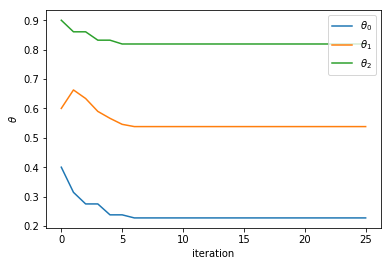

In [4]:
for i in range(3):
    plt.plot(vq.history_thera_coins[:,i],label=r'$\theta_{}$'.format(i))

plt.ylabel(r'$\theta$')
plt.xlabel('iteration')
plt.legend()
plt.show() 

# Expectation Maximization

Given three coins A, B, and C of unknown biases, $\theta_A$, $\theta_B$, and $\theta_C$ and set of training example, 
the goal of this code is to  etimate the parameters of the model $\Theta = (\theta_A, \theta_B, \theta_C)$.  The code is based on the following paper and you are highly encouraged to read through the paper to fully understand the problem:

 * Do, Chuong B., and Serafim Batzoglou. "What is the expectation maximization algorithm?." Nature biotechnology 26.8 (2008): 897-899.

The observed features are sequences of twenty heads (H) and tails (T) coming from three unfair coins.

### Model
Since the outcome of each coin is either head or tail, a Bernoulli distribution describes the outcome. 

\begin{equation}
p(H | \theta_A) = \theta_A^H (1-\theta_A)^{T}
\end{equation}

Log-likelihood score is given by:
$$L(\Theta|\textbf{X})=\sum_{i=1}^N{\log\sum_{k=1}^3{\pi_k p(X_i|\theta_k)}}$$

In [5]:
class EM_alg:
    def __init__(self, filename='seq_H_T.txt', n_coin=3):
        X = np.loadtxt(filename)
        self.n_samp, self.n_dim = X.shape
        self.H = np.sum(X,axis=1)
        self.T = self.n_dim - self.H
        self.n_coin = n_coin
        
        self. Iter = 25  # number of iterations 
        
        
        # theta
        init_theta = [0.4, 0.6, 0.9]
        self.p_coin_given_x = np.zeros((self.n_coin, self.n_samp))
        self.p_x_given_coin = np.zeros((self.n_coin, self.n_samp))

        self.LL = np.zeros(self.Iter)
        self.Theta_coins = [init_theta]
        self.LL = []
        
    def binom_prb(self, theta, H, T):
        return 1.0 * theta**H * (1-theta)**T 
    
    def EM(self):
        for iter in range(self.Iter):
            if iter == 0:
                theta_coins = self.Theta_coins[0]

                p_coins = [1.0/self.n_coin] * self.n_coin


            ## E-step
            for i in range(self.n_samp):
                for coin_id in range(self.n_coin):
                    self.p_x_given_coin[coin_id][i] = self.binom_prb(theta_coins[coin_id],self.H[i],self.T[i])
                    
                p_x = np.sum([p_coins[coin_id] * self.p_x_given_coin[coin_id][i] for coin_id in range(self.n_coin)])
                
                for coin_id in range(self.n_coin):
                    self.p_coin_given_x[coin_id][i] = 1.0 * self.p_x_given_coin[coin_id][i] * p_coins[coin_id] / p_x


            ## M-step
            # updating biases
            theta_coins =[ 1.0 * np.sum(self.p_coin_given_x[coin_id]*self.H) / 
                          (np.sum(self.p_coin_given_x[coin_id]*self.H) +         
                           np.sum(self.p_coin_given_x[coin_id]*self.T)) 
                          for coin_id in range(self.n_coin)]

            # updating priors

            p_coins = [1.0 * np.sum(self.p_coin_given_x[coin_id])/self.n_samp for coin_id in range(self.n_coin)]


            p_LL=0
            for i in range(self.n_samp):
                p_LL = p_LL + np.log(np.sum([p_coins[coin_id] * self.p_x_given_coin[coin_id][i]
                                             for coin_id in range(self.n_coin)]))
            self.LL.append(1.0 * p_LL)

            self.Theta_coins.append(theta_coins)
        self.Theta_coins = np.array(self.Theta_coins)


In [6]:
t = EM_alg()
t.EM()

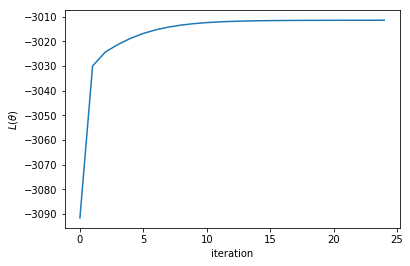

In [7]:
plt.plot(t.LL)
plt.ylabel('LL')
plt.ylabel(r'$L(\theta)$')
plt.xlabel('iteration')
plt.show()

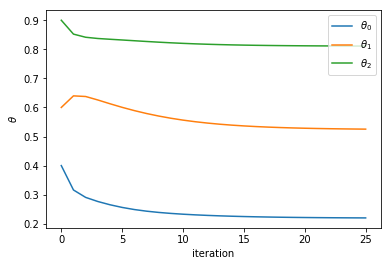

In [8]:
for i in range(3):
    plt.plot(t.Theta_coins[:,i],label=r'$\theta_{}$'.format(i))

plt.ylabel(r'$\theta$')
plt.xlabel('iteration')
plt.legend()
plt.show() 